# Brain MRI Image Segmentation using Pytorch

### Name: 
* Chirag Rana = 2018130043
* Shobhit Verma = 2018130062


# Table of Content

We will cover the following topics in this tutorial:
- [Introduction](#1)
- [Importing the libraries](#2)
- [Dataset Description](#3)
- [Data Loading](#4)
- [Visualization of Data](#5)
- [Data Preparation](#6)
- [Data Preprocessing](#7)
- [Building Unet model](#8)
- [Model Training](#9)
- [Loss vs Epoch](#10)
- [Visualization of Results](#11)
- [Final Results](#12)
- [Conclusion](#13)



# Introduction
<a id="1"></a>
Image segmentation plays an important role in medical image processing, and is a key technique to analysis, understand and describe medical images in order to diagnose curious diseases. Accurate brain tissue segmentation can improve reliability of brain disease diagnosis and effectiveness of treatment. But brain MRI images mostly contain noise, intensity nonuniformity, etc., therefore, accurate segmentation of brain MRI images is a very difficult task.

![](https://mateuszbuda.github.io/images/brainseg/brain-mri-lgg.png)


In this notebook, We have used 3929 images to perform this experiment. Througout the notebook we have used Pytorch to preprocess, build, Train and evaluate out model. For Model we have used Unet architecture which is heavily used in the medical domain for image segmentation process.

# Importing the Libraries
<a id="2"></a>

In [2]:
import os
import monai # Medical Open Network for AI version 0.8.0
import torch, torchvision # Pytorch
import skimage
import numpy as np 
import pandas as pd 
from glob import glob
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from imio import load, save
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Spacingd,
    Resized,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    ToTensor,
    ToTensord,
    Orientationd,
    NormalizeIntensityd,
    RandRotated,
    RandAxisFlipd,
    RandFlipd,
    AdjustContrastd,
)
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

# Dataset Description
<a id ="3"></a>

Dataset used in:
Mateusz Buda, AshirbaniSaha, Maciej A. Mazurowski "Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm." Computers in Biology and Medicine, 2019.
and
Maciej A. Mazurowski, Kal Clark, Nicholas M. Czarnek, Parisa Shamsesfandabadi, Katherine B. Peters, Ashirbani Saha "Radiogenomics of lower-grade glioma: algorithmically-assessed tumor shape is associated with tumor genomic subtypes and patient outcomes in a multi-institutional study with The Cancer Genome Atlas data." Journal of Neuro-Oncology, 2017.

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.

link to the Dataset: [Dataset](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

<a id= "4"></a>
# Data Loading
Loading and performing operations on medical dataset is quite tricky to get started with. Since unlike **png**, **jpg** which in general we are used to, <br> we may have to deal with images with different file types like **DICOM**, **NifTi**, e.t.c. .
And the file type which we will be dealing with is **TIFF**. (Tag Image File Format)

Lgg-mri-segmentation containes a folder kaggle_3m which contains several data points or folders that  represents individual patients. <br>
And each patient have certain no of slices in the voxel.(images of various slices of the brain).  <br>
**We will create two arrays  containing file name of Brain MRI and there respective Masks.** 

In [3]:
# Mask Files
mask_files = sorted(glob('data/lgg-mri-segmentation/kaggle_3m/*/*_mask*'))
# print(mask_files[0:5])

In [4]:
# Brain MRI Images
training_files = []
for path in mask_files:
    training_files.append(path.replace('_mask',''))

# Data Visualization
<a id="5"></a>

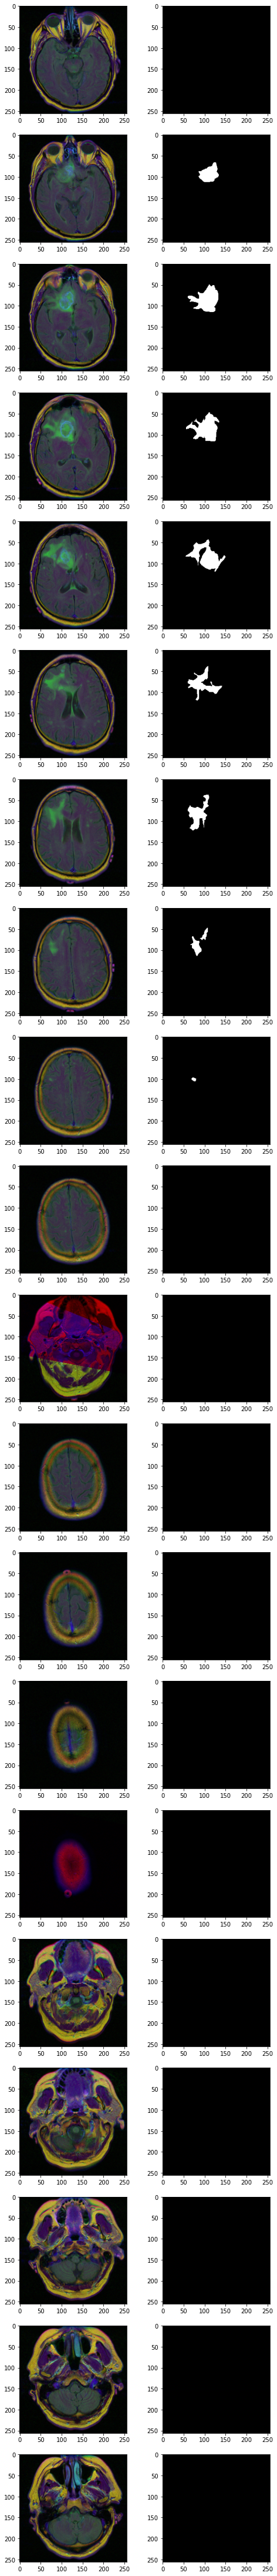

In [5]:
rows = 20
fig,ax = plt.subplots(rows,2,figsize=(8,80))
for i in range(rows):
    read1 = plt.imread(training_files[i])
    read2 = plt.imread(mask_files[i])
    ax[i,0].imshow(read1)
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

So we can see that there are cases in which we dont have masks these cases can leed to difficulty in the learninig of our model.
Below we will caculate how many images do have mask and how many do not.


In [6]:
# will tell us if a image has mask or not
def is_mask(path):
    mask = plt.imread(path)
    if np.max(mask) != 0.0:
        return 1
    else:
        return 0

Creating a DataFrame consisting of image location, mask location and boolean value whether the image has a tumor or not

In [7]:
df = pd.DataFrame({'training_files':training_files,'mask_files':mask_files})
df['mask'] = df['mask_files'].apply(lambda x: is_mask(x))

In [8]:
df.head()

training_files  \
0  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...   
1  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...   
2  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...   
3  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...   
4  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...   

                                          mask_files  mask  
0  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...     0  
1  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...     1  
2  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...     1  
3  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...     1  
4  data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_49...     1

In [9]:
df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

So lets reorganize or data to only containe data points with Masks.


In [10]:
data = df[df['mask']==1]

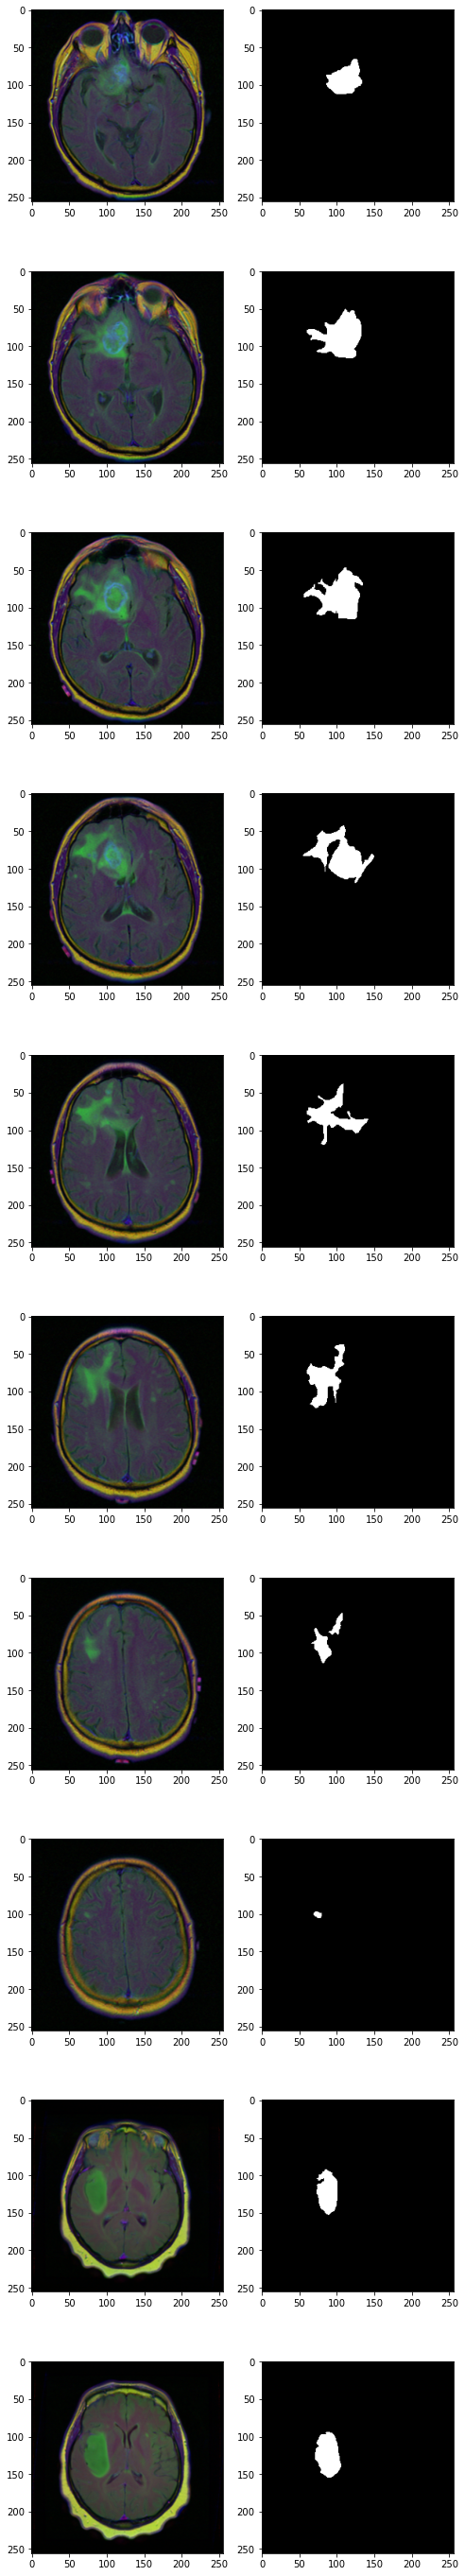

In [11]:
rows = 10
fig,ax = plt.subplots(rows,2,figsize=(8,50))
for i in range(rows):
    read1 = plt.imread(data['training_files'].iloc[i])
    read2 = plt.imread(data['mask_files'].iloc[i])
    ax[i,0].imshow(read1,cmap='gray')
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

# Data Preparations
<a id="6"></a>
In this section we will do two steps--

1. Converting the images from .tff to .nii format since it is a very efficient way when using monai and Pytorch or with medical data in general.

2. Converting the colored images into GrayScale images since It will reduce the model coplexity a lot and it also helps the model to converge very quickly.

In [12]:
# Creating Dir to store the converted files
dir = './new_data'
mask_out_path = './new_data/mask'
input_out_path = './new_data/input'
# os.mkdir(dir)
# os.mkdir(mask_out_path)
# os.mkdir(input_out_path)

In [13]:
# Traning Files
for path in data['training_files']:
    img = plt.imread(path)
    img = skimage.color.rgb2gray(img)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(input_out_path,name))

In [14]:
# Mask Files
for path in data['mask_files']:
    img = plt.imread(path)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(mask_out_path,name))

# Data Preprocessing & Augmentation 
<a id="7"></a>

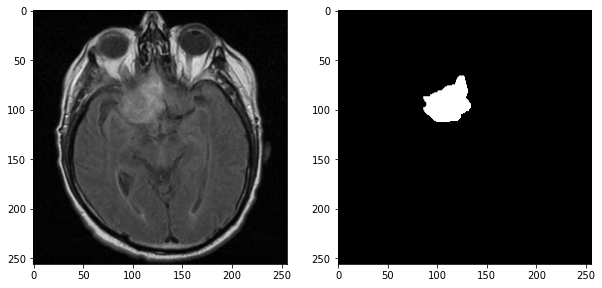

In [15]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
img = skimage.color.rgb2gray(plt.imread(data['training_files'].iloc[0]))
mask = plt.imread(data['mask_files'].iloc[0])
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,cmap='gray')

From the Above images we can identify two things
1. The size of the image is **250x250** which is large enough cause issues while fitting in my **GPU Memory**, so we will resize the image to 128x128

2. As we can see that It is difficult to see the tumor in the Brain MRI. To resolve this we can **strach contrast** accordingly. 

In [16]:
# First we have to get that .nii data
filenames = []
img = sorted(glob('./new_data/input/*'))
mask = sorted(glob('./new_data/mask/*'))
for i in range(len(img)):
    filenames.append({'img':img[i],'mask':mask[i]})

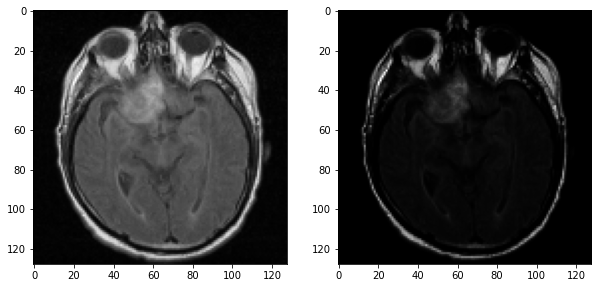

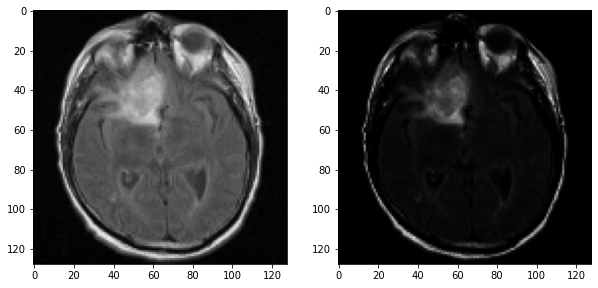

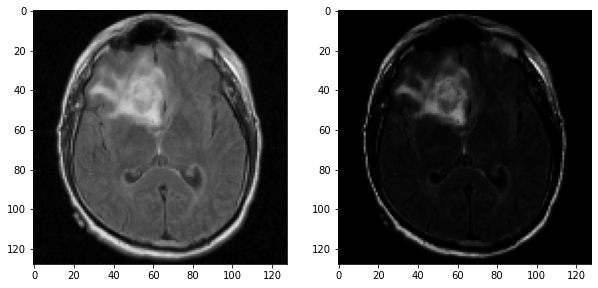

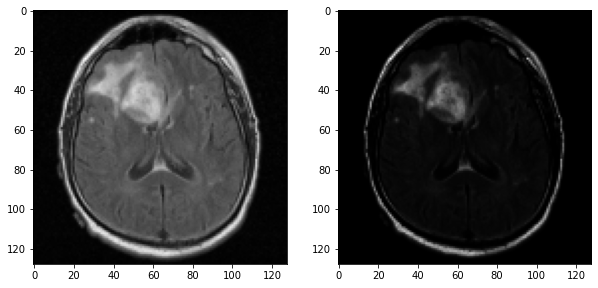

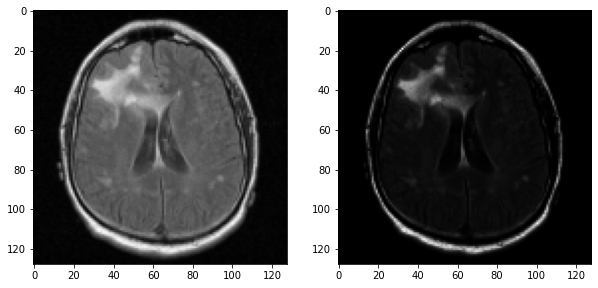

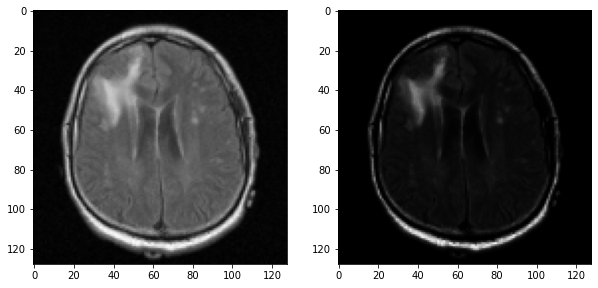

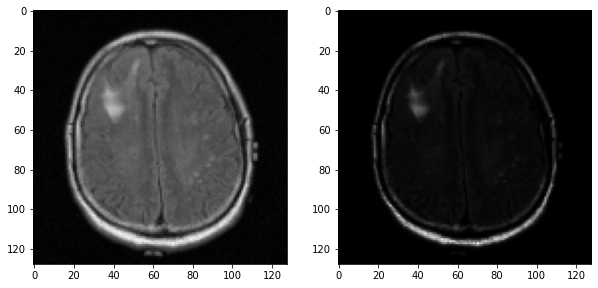

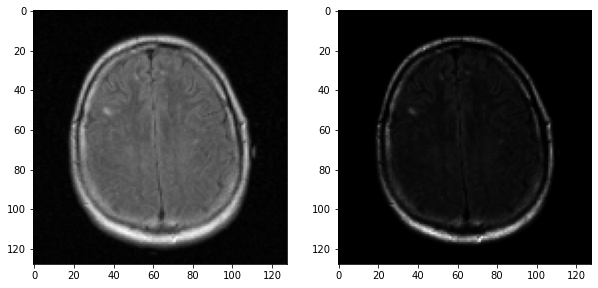

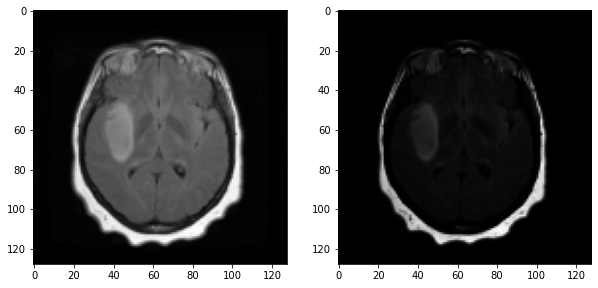

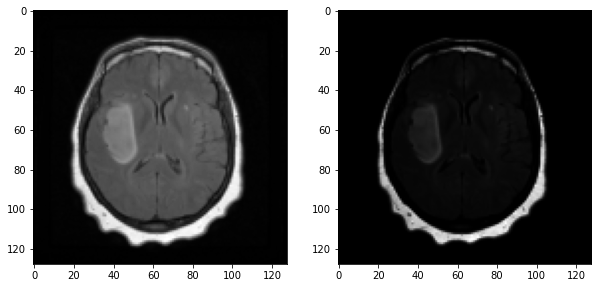

In [17]:
for i in range(0,10):
  li = LoadImaged(keys=['img','mask'])
  li_img = li(filenames[i])
  li_img['img'].shape

  add = AddChanneld(keys=['img','mask'])
  add_img = add(li_img)

  res = Resized(spatial_size  = (128,128),keys=['img'])
  res_img = res(add_img)
  res_img['img'].shape
  
  si = AdjustContrastd(keys=["img"],gamma=3)
  si_img = si(res_img)
  fig,ax = plt.subplots(1,2,figsize=(10,5))
  ax[0].imshow(res_img['img'][0,:,:],cmap='gray')
  ax[1].imshow(si_img['img'][0,:,:],cmap='gray')

In [18]:
preprocess = Compose([
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    AdjustContrastd(keys="img",gamma=2),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),  
    
])


By using **AdjustedContrastd** ach pixel/voxel intensity is updated as:\
`x = ((x - min) / intensity_range) ^ gamma * intensity_range + min`
and **NormalizeIntensityd** this transform will normalize only non-zero values or entire image, and will also calculate mean and std on each channel separately.

In [19]:
# Preparing the DataSet
train_data = Dataset(data = filenames,transform = preprocess)

We have split the dataset to 70% training, 20% validation and 10% testing.

In [20]:
from torch.utils.data import random_split
val = int((len(train_data)/100)*20) # 20%
test = int((len(train_data)/100)*10) # 10%
org = len(train_data)-val - test
print(val, test, org)
train_ds,test_ds,val_ds = random_split(train_data,[org,test,val])

274 137 962


In [21]:
train_loder = DataLoader(train_ds,batch_size = 1)
val_loder = DataLoader(val_ds,batch_size = 1)
test_loader = DataLoader(test_ds, batch_size = 1)

# Building the UNet Model
<a id="8"></a>

### Unet Model Architecture
![](https://miro.medium.com/max/680/1*TXfEPqTbFBPCbXYh2bstlA.png)

Unet model is used in the medical Image segmentation industry for semantci Segmentation.it Uses Convolutional Neural Network as its backbone and has an  Encoding and Decoding model Architecture as shown in te image 

### Model from Scratch

In [22]:
class ConvBlock(nn.Module):
    
    def __init__(self,input_ch,output_ch,kernal_size=3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_ch,output_ch,kernal_size)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(output_ch,output_ch,kernal_size)

    def forward(self,x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))
    
class Encoder(nn.Module):
    def __init__(self,layers=[3,64,128,256,512,1024],kernal_size = 3,pool = 2):
        super().__init__()
        self.encoder = nn.ModuleList([ConvBlock(layers[i],layers[i+1],kernal_size) for i in range(len(layers)-1)])
        self.pool_layer = nn.MaxPool2d(pool)

    def forward(self,x):
        encoder = []
        for block in self.encoder:
           
            x = block(x)
            encoder.append(x)
            x = self.pool_layer(x)
        return encoder

class Decoder(nn.Module):
    def __init__(self,layers = [1024,512,256,128,64],kernal_size=3):
        super().__init__()
        self.layers = layers
        self.decoder = nn.ModuleList([ConvBlock(layers[i],layers[i+1],kernal_size) for i in range(len(layers)-1)])
        self.upconv  = nn.ModuleList([nn.ConvTranspose2d(layers[i],layers[i+1],2,2) for i in range(len(layers)-1)])
        
    def forward(self,x,encoder):
        for i in range(len(self.layers)-1):
            x = self.upconv[i](x) 
            connect = self.crop(encoder[i],x)
            x = torch.cat([x,connect],dim=1)
            x = self.decoder[i](x)
        return x
    
    def crop(self,input_tensor,target_tensor):
        _,_,H,W = target_tensor.shape
        reshaped   = torchvision.transforms.CenterCrop([H, W])(input_tensor)
        return reshaped

In [23]:
class Unet(nn.Module):
    def __init__(self,encoder_layers=[3,64,128,256],decoder_layers = [256,128,64],retain_dimension = True, num_class = 1,outputsize = (128,128) ):
        super().__init__()
        self.encoder = Encoder(encoder_layers)
        self.decoder = Decoder(decoder_layers)
        self.output = nn.Conv2d(decoder_layers[-1],num_class,1)
        self.retain_dimension = retain_dimension
        self.outputsize = outputsize
        
    def forward(self,x):
        enco = self.encoder(x)
        output = self.decoder(enco[::-1][0],enco[::-1][1:])
        output = self.output(output)
        if self.retain_dimension:
            output = F.interpolate(output,self.outputsize)
        return output

In [24]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = torch.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

### Model from Monai

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [26]:
model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64,128,256,512),
        dropout=0.3,
        strides=(2, 2, 2, 2,2),
        num_res_units=3,
    ).to(device)

In [27]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [28]:
num_epochs = 50
epoch_loss_values = []
val_loss_values = []

# Model Traning
<a id = "9"></a>

In [29]:
# Model Traning
for epoch in (range(num_epochs)):
        print("-" * num_epochs)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        avg_val_loss = 0
        step = 0
        print('traning')
        for batch_data in tqdm(train_loder):
            step += 1
            inputs, labels = torch.reshape(batch_data['img'],(1,1,128,128)).to(device), batch_data['mask'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loder.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        ii = 0
        for batch in tqdm(val_loder):#val_patient
            ii+=1
            inputs, labels = torch.reshape(batch['img'],(1,1,128,128)).to(device), batch['mask'].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            avg_val_loss+=loss.item()
        avg_val_loss = avg_val_loss/ii
        val_loss_values.append(avg_val_loss)
       
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f} validation_loss: {avg_val_loss:.4f}")

--------------------------------------------------
epoch 1/50
traning


100%|██████████| 274/274 [00:05<00:00, 48.88it/s]


epoch 1 average loss: 0.8117 validation_loss: 0.6586
--------------------------------------------------
epoch 2/50
traning


100%|██████████| 274/274 [00:04<00:00, 57.95it/s]


epoch 2 average loss: 0.5645 validation_loss: 0.5104
--------------------------------------------------
epoch 3/50
traning


100%|██████████| 274/274 [00:04<00:00, 58.99it/s]


epoch 3 average loss: 0.4758 validation_loss: 0.4646
--------------------------------------------------
epoch 4/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.15it/s]


epoch 4 average loss: 0.4377 validation_loss: 0.4259
--------------------------------------------------
epoch 5/50
traning


100%|██████████| 274/274 [00:04<00:00, 62.88it/s]


epoch 5 average loss: 0.4176 validation_loss: 0.4212
--------------------------------------------------
epoch 6/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.05it/s]


epoch 6 average loss: 0.4059 validation_loss: 0.3985
--------------------------------------------------
epoch 7/50
traning


100%|██████████| 274/274 [00:04<00:00, 58.98it/s]


epoch 7 average loss: 0.3920 validation_loss: 0.3923
--------------------------------------------------
epoch 8/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.68it/s]


epoch 8 average loss: 0.3813 validation_loss: 0.3843
--------------------------------------------------
epoch 9/50
traning


100%|██████████| 274/274 [00:04<00:00, 61.13it/s]


epoch 9 average loss: 0.3731 validation_loss: 0.3790
--------------------------------------------------
epoch 10/50
traning


100%|██████████| 274/274 [00:04<00:00, 62.10it/s]


epoch 10 average loss: 0.3635 validation_loss: 0.3616
--------------------------------------------------
epoch 11/50
traning


100%|██████████| 274/274 [00:04<00:00, 61.00it/s]


epoch 11 average loss: 0.3572 validation_loss: 0.3717
--------------------------------------------------
epoch 12/50
traning


100%|██████████| 274/274 [00:04<00:00, 61.49it/s]


epoch 12 average loss: 0.3515 validation_loss: 0.3584
--------------------------------------------------
epoch 13/50
traning


100%|██████████| 274/274 [00:04<00:00, 61.02it/s]


epoch 13 average loss: 0.3428 validation_loss: 0.3577
--------------------------------------------------
epoch 14/50
traning


100%|██████████| 274/274 [00:04<00:00, 61.65it/s]


epoch 14 average loss: 0.3356 validation_loss: 0.3533
--------------------------------------------------
epoch 15/50
traning


100%|██████████| 274/274 [00:04<00:00, 62.11it/s]


epoch 15 average loss: 0.3302 validation_loss: 0.3461
--------------------------------------------------
epoch 16/50
traning


100%|██████████| 274/274 [00:04<00:00, 59.76it/s]


epoch 16 average loss: 0.3367 validation_loss: 0.3377
--------------------------------------------------
epoch 17/50
traning


100%|██████████| 274/274 [00:04<00:00, 64.13it/s]


epoch 17 average loss: 0.3233 validation_loss: 0.3405
--------------------------------------------------
epoch 18/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.35it/s]


epoch 18 average loss: 0.3190 validation_loss: 0.3381
--------------------------------------------------
epoch 19/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.36it/s]


epoch 19 average loss: 0.3211 validation_loss: 0.3631
--------------------------------------------------
epoch 20/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.68it/s]


epoch 20 average loss: 0.3133 validation_loss: 0.3366
--------------------------------------------------
epoch 21/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.40it/s]


epoch 21 average loss: 0.3192 validation_loss: 0.3187
--------------------------------------------------
epoch 22/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.42it/s]


epoch 22 average loss: 0.3098 validation_loss: 0.3226
--------------------------------------------------
epoch 23/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.86it/s]


epoch 23 average loss: 0.2940 validation_loss: 0.3463
--------------------------------------------------
epoch 24/50
traning


100%|██████████| 274/274 [00:04<00:00, 62.48it/s]


epoch 24 average loss: 0.3037 validation_loss: 0.3173
--------------------------------------------------
epoch 25/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.55it/s]


epoch 25 average loss: 0.2973 validation_loss: 0.3123
--------------------------------------------------
epoch 26/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.33it/s]


epoch 26 average loss: 0.2961 validation_loss: 0.3122
--------------------------------------------------
epoch 27/50
traning


100%|██████████| 274/274 [00:04<00:00, 62.97it/s]


epoch 27 average loss: 0.2840 validation_loss: 0.3124
--------------------------------------------------
epoch 28/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.17it/s]


epoch 28 average loss: 0.2890 validation_loss: 0.3238
--------------------------------------------------
epoch 29/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.31it/s]


epoch 29 average loss: 0.2897 validation_loss: 0.3090
--------------------------------------------------
epoch 30/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.06it/s]


epoch 30 average loss: 0.2843 validation_loss: 0.3138
--------------------------------------------------
epoch 31/50
traning


100%|██████████| 274/274 [00:04<00:00, 62.00it/s]


epoch 31 average loss: 0.2817 validation_loss: 0.2957
--------------------------------------------------
epoch 32/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.38it/s]


epoch 32 average loss: 0.2855 validation_loss: 0.3026
--------------------------------------------------
epoch 33/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.60it/s]


epoch 33 average loss: 0.2773 validation_loss: 0.2945
--------------------------------------------------
epoch 34/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.47it/s]


epoch 34 average loss: 0.2734 validation_loss: 0.2945
--------------------------------------------------
epoch 35/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.33it/s]


epoch 35 average loss: 0.2735 validation_loss: 0.2948
--------------------------------------------------
epoch 36/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.40it/s]


epoch 36 average loss: 0.2690 validation_loss: 0.3014
--------------------------------------------------
epoch 37/50
traning


100%|██████████| 274/274 [00:04<00:00, 61.74it/s]


epoch 37 average loss: 0.2715 validation_loss: 0.2908
--------------------------------------------------
epoch 38/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.76it/s]


epoch 38 average loss: 0.2688 validation_loss: 0.2919
--------------------------------------------------
epoch 39/50
traning


100%|██████████| 274/274 [00:04<00:00, 60.10it/s]


epoch 39 average loss: 0.2682 validation_loss: 0.2819
--------------------------------------------------
epoch 40/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.27it/s]


epoch 40 average loss: 0.2637 validation_loss: 0.2960
--------------------------------------------------
epoch 41/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.13it/s]


epoch 41 average loss: 0.2659 validation_loss: 0.2899
--------------------------------------------------
epoch 42/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.67it/s]


epoch 42 average loss: 0.2657 validation_loss: 0.2758
--------------------------------------------------
epoch 43/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.42it/s]


epoch 43 average loss: 0.2557 validation_loss: 0.3000
--------------------------------------------------
epoch 44/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.49it/s]


epoch 44 average loss: 0.2565 validation_loss: 0.2759
--------------------------------------------------
epoch 45/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.42it/s]


epoch 45 average loss: 0.2526 validation_loss: 0.2822
--------------------------------------------------
epoch 46/50
traning


100%|██████████| 274/274 [00:04<00:00, 63.51it/s]


epoch 46 average loss: 0.2491 validation_loss: 0.2901
--------------------------------------------------
epoch 47/50
traning


100%|██████████| 274/274 [00:06<00:00, 39.80it/s]


epoch 47 average loss: 0.2513 validation_loss: 0.2852
--------------------------------------------------
epoch 48/50
traning


100%|██████████| 274/274 [00:06<00:00, 43.81it/s]


epoch 48 average loss: 0.2539 validation_loss: 0.2819
--------------------------------------------------
epoch 49/50
traning


100%|██████████| 274/274 [00:06<00:00, 39.83it/s]


epoch 49 average loss: 0.2440 validation_loss: 0.2938
--------------------------------------------------
epoch 50/50
traning


100%|██████████| 274/274 [00:06<00:00, 43.83it/s]

epoch 50 average loss: 0.2475 validation_loss: 0.2800


# Loss vs Epoch
<a id="10"></a>

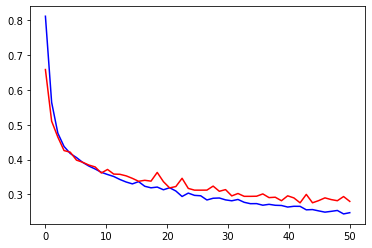

In [30]:
plt.plot(np.linspace(0,len(epoch_loss_values),len(epoch_loss_values)),epoch_loss_values,color='blue')
plt.plot(np.linspace(0,len(val_loss_values),len(val_loss_values)),val_loss_values,color='red')

# Visualizing the Results
<a id="11"></a>

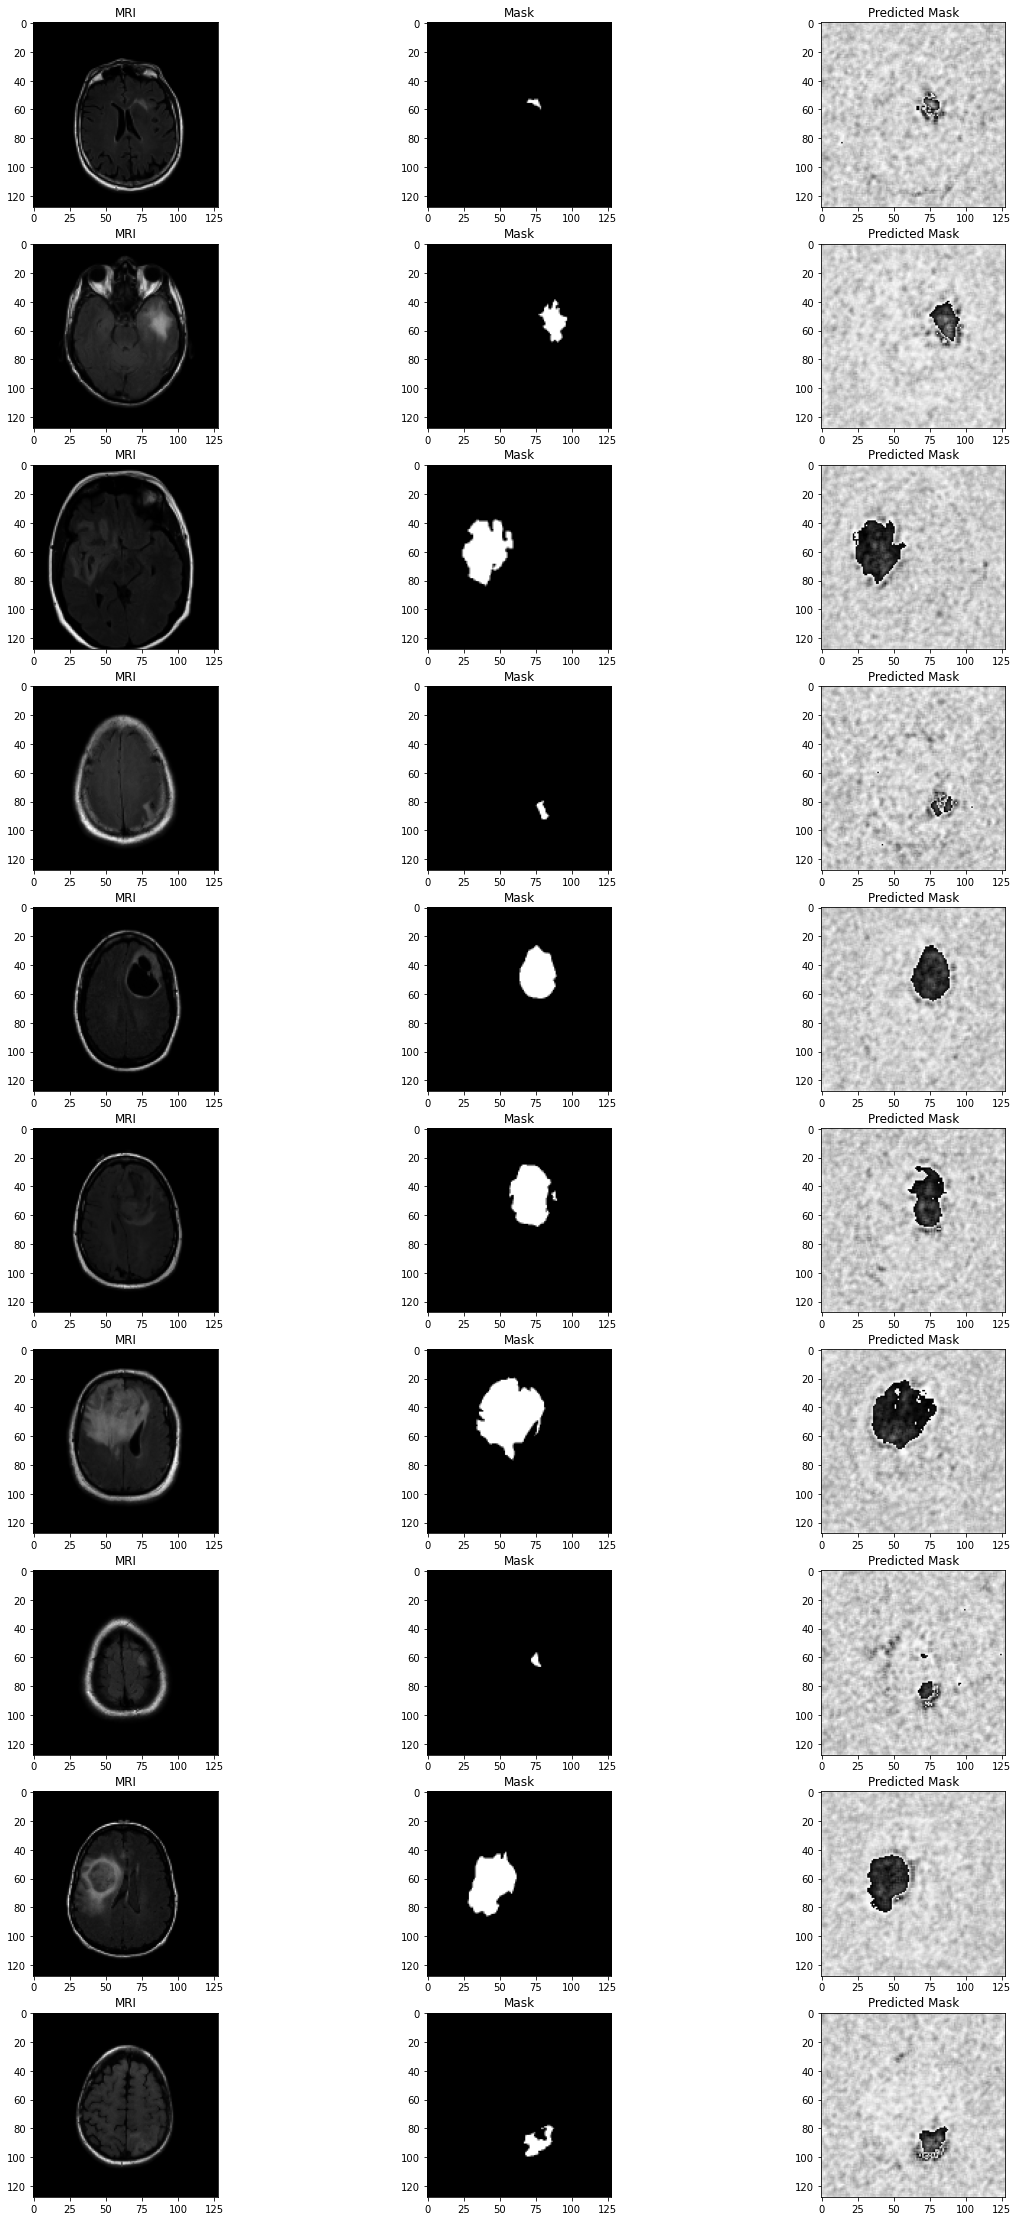

In [31]:
r = 10
i=0
fig,ax = plt.subplots(r,3,figsize=(20,40))
for batch in val_loder:
    inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
    out = model(inp).to('cpu')
    ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
    ax[i,0].title.set_text('MRI')
    ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
    ax[i,1].title.set_text('Mask')
    ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
    ax[i,2].title.set_text('Predicted Mask')
    if i>=r-1:
        break
    i=i+1
    
      

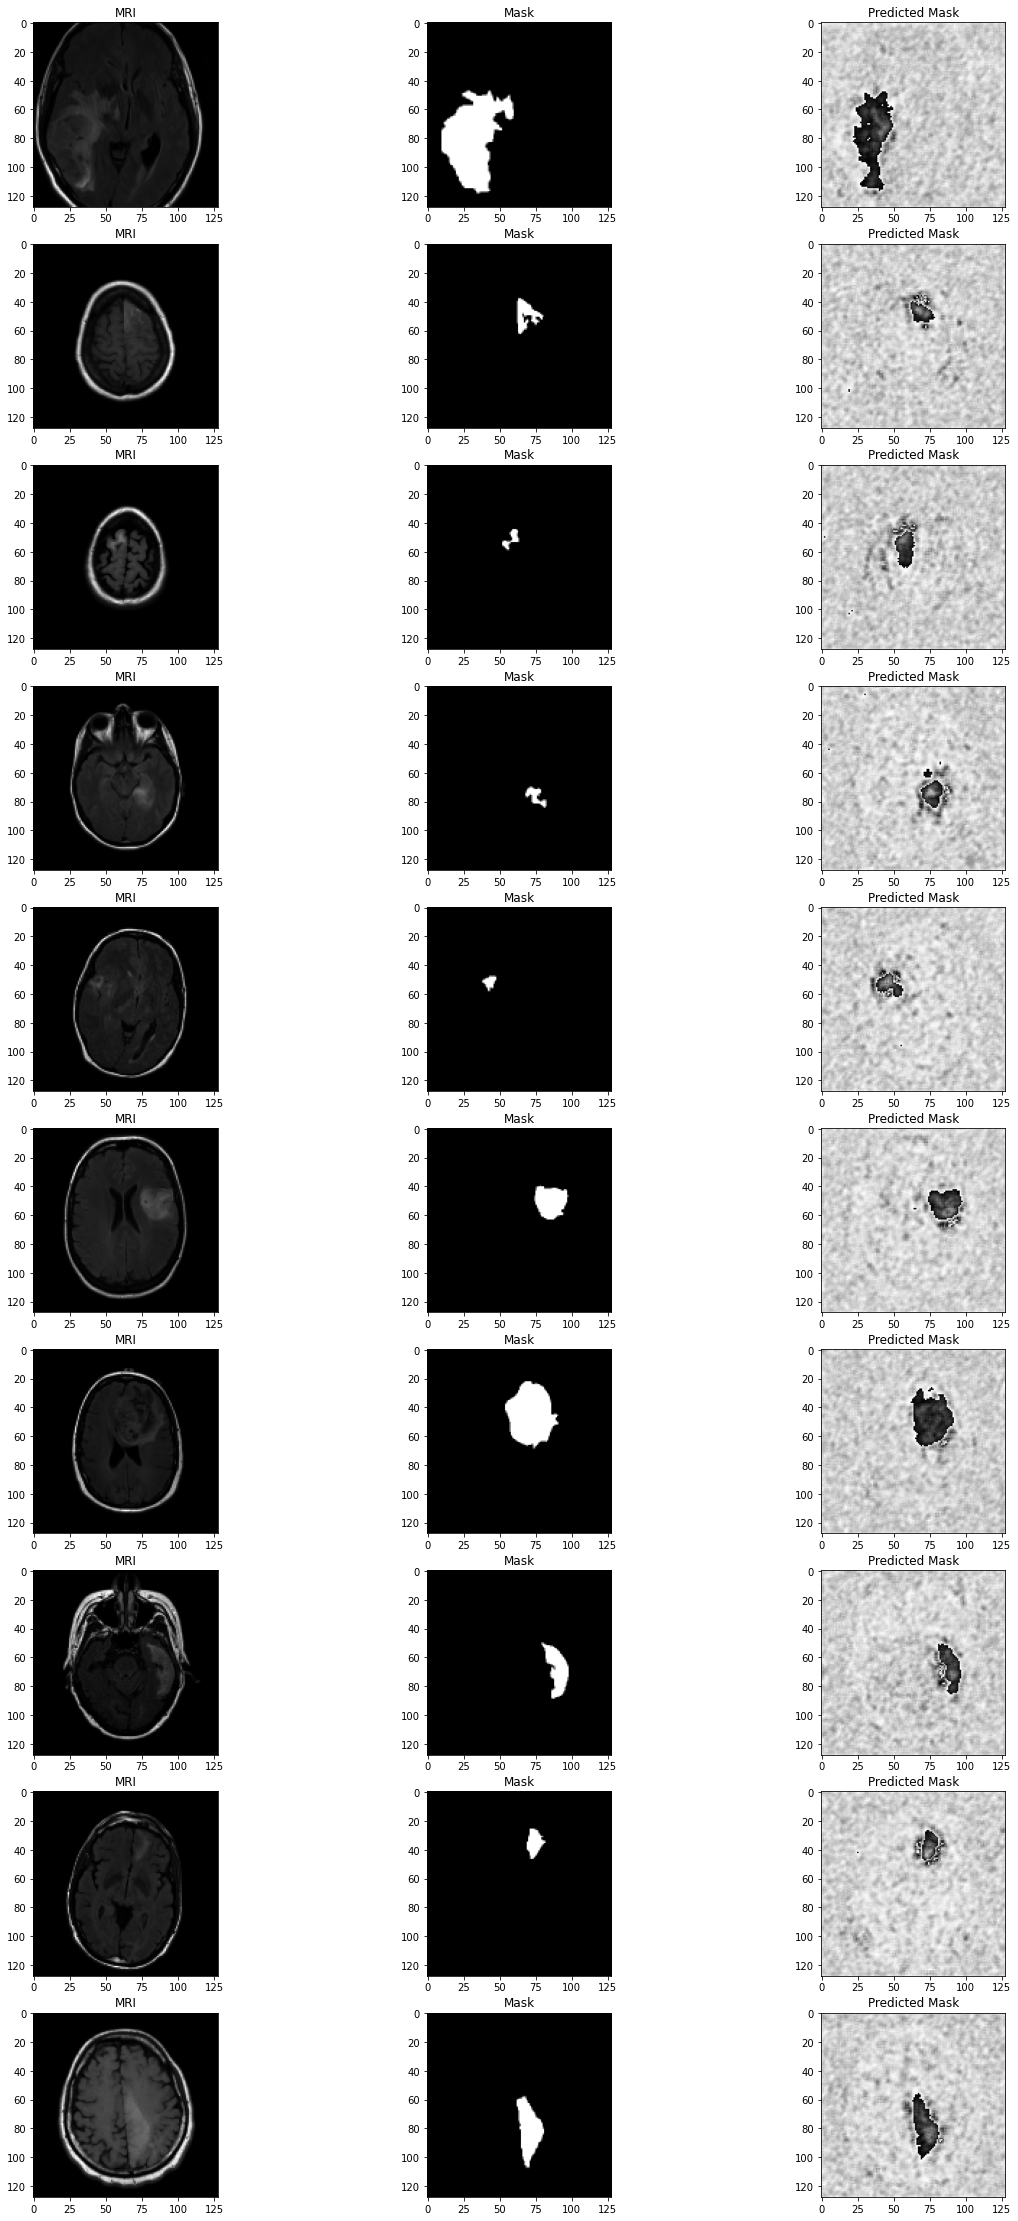

In [32]:
r = 10
i=0
fig,ax = plt.subplots(r,3,figsize=(20,40))
for batch in test_loader:
    inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
    out = model(inp).to('cpu')
    ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
    ax[i,0].title.set_text('MRI')
    ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
    ax[i,1].title.set_text('Mask')
    ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
    ax[i,2].title.set_text('Predicted Mask')
    if i>=r-1:
        break
    i=i+1

### Results on Test Dataset

In [33]:
avg_test_loss = 0
ii = 0
for batch in test_loader: # testloader
    ii+=1
    inputs, labels = torch.reshape(batch['img'],(1,1,128,128)).to(device), batch['mask'].to(device)
    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    avg_test_loss+=loss.item()
avg_test_loss = avg_test_loss/ii
print("Average Dice Loss on Test DataSet: ",avg_test_loss)

Average Dice Loss on Test DataSet:  0.3065900197864449


## Final Results
<a id="12"></a>
Dice Loss on Training Set: 0.2475, Validation Set: 0.2800 and Test Set: 0.3066

# Conclusion and References
<a id = "13"></a>
This tutorial we have highlighted a method to perform Instance Segmentation to detect brain tumors. Image Segmentation proves to be a very impactful tool in the medical industry. We learned about the various Preprocessing Methods to perform image processing and improve data to fit and assist the model in getting a better performance. The preprocessed data after normalization and adjusting the contrast support the model to run more efficiently. By using U-Net for Image segmentation we received a DICE loss of 0.3066 on Test Data.

References
1. [Pytorch](https://pytorch.org/)
2. [Monia for Pytorch](https://docs.monai.io/en/stable/index.html)
3. [Dataset](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)
4. [Imio](https://pypi.org/project/imio/)
5. [Scikit Image](https://scikit-image.org/)
6. [NumPy](https://numpy.org/)
7. [Pandas](https://pandas.pydata.org/)
8. [Matplot Lib](https://matplotlib.org/)
9. [Anaconda - Environment](https://anaconda.org/anaconda/anaconda-navigator)